# Carrier frequency figure

In [1]:
%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")
from brian2 import *
from collections import OrderedDict
from matplotlib import cm
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv, to_rgba
import matplotlib.patches as patches
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.filters import gaussian_filter, median_filter, minimum_filter
from simple_model import *
from model_explorer_jupyter import meshed_arguments
import time

def normed(X, *args):
    m = max(amax(abs(Y)) for Y in (X,)+args)
    return X/m

In [2]:
def rmse(x, y, axis=1):
    return sqrt(mean((x-y)**2, axis=axis))

def maxnorm(x, y, axis=1):
    return amax(abs(x-y), axis=axis)

error_functions = {
    'RMS error': rmse,
    'Max error': maxnorm,
    }

In [3]:
latex_parameter_names = dict(
    taue_ms=r"$\tau_e$ (ms)",
    taui_ms=r"$\tau_i$ (ms)",
    taua_ms=r"$\tau_a$ (ms)",
    alpha=r"$\alpha$",
    beta=r"$\beta$",
    gamma=r"$\gamma$",
    level=r"$L$ (dB)",
    tauihc_ms=r"$\tau_\mathrm{IHC}$ (ms)",
    )

This is the cell types figure adapted to the carrier frequency analysis.

In [4]:
def where_close_to_best(mse, max_error):
    #mse_best = amin(mse, axis=2)
    #return abs(mse-mse_best[:, :, newaxis])<max_error
    return mse<max_error

def fraction_close_to_best(whereclose):
    return sum(whereclose, axis=2)*1.0/whereclose.shape[2]

def desaturate(img, saturation):
    # assume img is rgb shape (M, M, 3)
    img = rgb_to_hsv(img)
    img[:, :, 1] *= saturation
    img = hsv_to_rgb(img)
    return img

def pop_summary(mse, arr, max_error=30, vmin=None, vmax=None):
    # if arr is mse just return the best
    if mse is arr:
        return amin(mse, axis=2)
    # compute where is close to best
    whereclose = where_close_to_best(mse, max_error)
    # compute mean across close values
    arr_mean = (1.0*sum(arr*whereclose, axis=2))/sum(whereclose, axis=2)
    # normalise range
    if vmin is None:
        vmin = nanmin(arr_mean)
    if vmax is None:
        vmax = nanmax(arr_mean)
    arr_mean = (arr_mean-vmin)/(vmax-vmin)
    # compute range across close values and all values
    arr_nans = arr.copy()
    arr_nans[~whereclose] = nan
    arr_std_close = nanmax(arr_nans, axis=2) - nanmin(arr_nans, axis=2)
    arr_std_all = amax(arr, axis=2)-amin(arr, axis=2)
    saturation = 1-arr_std_close/arr_std_all
    # convert to rgb
    img = cm.viridis(arr_mean)[:, :, :3] # discard alpha
    # desaturate image
    img = desaturate(img, saturation**2)
    # hide values where nothing is good
    img = dstack((img, sum(whereclose, axis=2)>0))
    return img

def plot_cell_types(M, num_params, params,
                    weighted, error_func_name,
                    max_error=45, discount_200=3.):
    # always use the same random seed for cacheing
    seed(34032483)    
    # Set up ranges of variables, and generate arguments to pass to model function
    vx, vy = selected_axes = ('alpha', 'beta')
    error_func = error_functions[error_func_name]
    axis_ranges = dict((k, linspace(*(v+(M,)))) for k, v in params.items() if k in selected_axes)
    axis_ranges['temp'] = zeros(num_params)
    array_kwds = meshed_arguments(selected_axes+('temp',), params, axis_ranges)
    del array_kwds['temp']
    # run the model at 500 Hz
    array_kwds['fc_Hz'] = 500
    seed(342309432)
    res500 = simple_model(M*M*num_params, array_kwds, update_progress='text', use_standalone_openmp=True)
    res500 = simple_model_results(M*M*num_params, res500, error_func, weighted=weighted,
                                  interpolate_bmf=True, shape=(M, M, num_params))
    # run the model at 200 Hz
    array_kwds['fc_Hz'] = 200
    seed(342309432)
    res200 = simple_model(M*M*num_params, array_kwds, update_progress='text', use_standalone_openmp=True)
    res200 = simple_model_results(M*M*num_params, res200, error_func, weighted=weighted,
                                  target_phase=ones(5)*pi,
                                  interpolate_bmf=True, shape=(M, M, num_params))
    # analyse
    res = res200
    mse = maximum(res500.mse, res200.mse/discount_200)
    mse = mse*180/pi
    mse_summary = pop_summary(mse, mse)#, vmin=0, max_error=max_error)
    # Define regions
    meanvs = mean(res.raw_measures['vs'], axis=3)
    regions = [('All', mse < max_error, 'k', 0.5),
              ]
    
    # Plot the data
    fig = figure(figsize=(10, 10))
    gs_maps = GridSpec(2, 9, left=.0, bottom=.7, top=1, width_ratios=[1]*8+[0.5])
    gs_hist = GridSpec(3, 4, left=.05, bottom=0.25, top=0.7)
    gs_ex = GridSpec(1, 5, left=.05, bottom=0.0, top=0.24)
    ordered_gridspecs = [gs_maps, gs_hist, gs_ex]

    def hatchback():
        p = patches.Rectangle((extent[0], extent[2]), extent[1]-extent[0], extent[3]-extent[2],
                              hatch='xxxx', fill=True, fc=(0.9,)*3, ec=(0.8,)*3, zorder=-10)
        gca().add_patch(p)

    # Map colourbar
    subplot(gs_maps[0:2, 8])
    s, v = meshgrid(linspace(0, 1, 20), linspace(0, 1, 20))
    img = cm.viridis(v)[:, :, :3] # convert to rgb, discard alpha
    img = desaturate(img, s**2) # desaturate image
    imshow(img, extent=(0, 1, 0, 1), origin='lower left', aspect='auto', interpolation='bilinear')
    xticks([0, 1], fontsize=8)
    xlabel('Tuning')
    ticklabels = gca().get_xticklabels()
    ticklabels[0].set_ha('left')
    ticklabels[-1].set_ha('right')
    yticks([0, 1], ['Min', 'Max'], rotation='vertical', fontsize=8)
    ticklabels = gca().get_yticklabels()
    ticklabels[0].set_va('bottom')
    ticklabels[-1].set_va('top')

    # Error map
    extent = (params[vx]+params[vy])
    subplot(gs_maps[0:2, 0:2]) # error
    #mse_summary = median_filter(mse_summary, mode='nearest', size=5)
    #mse_summary = minimum_filter(mse_summary, mode='nearest', size=3)
    mse_summary_blur = gaussian_filter(mse_summary, 1, mode='nearest')    
    imshow(mse_summary, origin='lower left', aspect='auto',
           interpolation='nearest', extent=extent, vmin=0, vmax=135)
    cs = contour(mse_summary_blur, origin='lower',
                 levels=[15, 30, 45], colors='w',
                 extent=extent)
    clabel(cs, colors='w', inline=True, fmt='%d')
    title('Max error (deg)')
    xlabel(r'Adaptation strength $\alpha$')
    ylabel(r'Onset strength $\beta$')

    # Property maps
    cell_properties = dict([
        ('tMTF', (meanvs, 0, 1)),
        ('tMD', (res.moddepth['vs'], 0, 1)),
        ('tBMF', (res.bmf['vs'], 4, 64)),
        ('rMD', (res.moddepth['mean'], 0, 1)),
        ('rBMF', (res.bmf['mean'], 4, 64)),
        ])
    for i, (name, (values, vmin, vmax)) in enumerate(cell_properties.items()):
        subplot(gs_maps[0, 2+i])
        title(name)
        imshow(pop_summary(mse, values, vmin=vmin, vmax=vmax, max_error=max_error),
               origin='lower left', aspect='auto',
               interpolation='nearest', extent=extent)
        xticks([])
        yticks([])
        hatchback()

    # Parameter maps
    for i, paramname in enumerate(set(params.keys())-set(['alpha', 'beta'])):
        subplot(gs_maps[1, 2+i])
        title(latex_parameter_names[paramname])
        v = reshape(res.raw.params[paramname], (M, M, num_params))
        low, high = params[paramname]
        imshow(pop_summary(mse, v, vmin=low, vmax=high, max_error=max_error),
               origin='lower left', aspect='auto',
               interpolation='nearest', extent=extent)
        xticks([])
        yticks([])
        hatchback()

    # Region examples
    ax_lf = subplot(gs_ex[0, 0])
    ax_hf = subplot(gs_ex[0, 1])
    ax_phase = subplot(gs_ex[0, 2])
    ax_rmtf = subplot(gs_ex[0, 3])
    ax_tmtf = subplot(gs_ex[0, 4])
    ax_lf.set_title(r'$f_m=4$ Hz')
    ax_hf.set_title(r'$f_m=64$ Hz')
    ax_rmtf.set_title('rMTF')
    ax_tmtf.set_title('tMTF')
    phase = linspace(0, 2*pi, 100)
    env = 0.5*(1-cos(phase))
    region_example_params = {}
    for ax in [ax_lf, ax_hf]:
        ax.fill_between(phase*180/pi, 0, env, color=(0.9,) * 3, zorder=-2)
        ax.set_xlabel('Phase (deg)')
        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xlim(0, 360)
        ax.set_yticks([])
        ax.set_ylim(0, 1)
    for ax in [ax_rmtf, ax_tmtf, ax_phase]:
        ax.set_xlabel(r'$f_m$')
        ax.set_xticks([4, 8, 16, 32, 64])
        ax.set_ylim(0, 1)
    ax_phase.errorbar(dietz_fm/Hz, dietz_phase*180/pi, yerr=dietz_phase_std*180/pi, fmt='--or', label='Data')
    ax_phase.set_ylim(0, 190)
    ax_phase.set_yticks([0, 45, 90, 135, 180])
    ax_phase.axhline(180, ls='--', c='k')
    ax_phase.set_title('Phase (deg)')
    for region_name, cond, col, alpha in regions[:1]:
        print "Region %s contains %.1f%% of good parameters" % (region_name, sum(cond)*100.0/sum(mse<max_error))        
        # Construct parameter values for that region
        region_example_params[region_name] = region_params = {}
        #for paramname in params.keys():
        #    values = reshape(res.raw.params[paramname], (M, M, num_params))
        #    values = values[cond]
        #    region_params[paramname] = median(values)
        idx_best = unravel_index(argmin(mse), mse.shape) # a triple
        for paramname in params.keys():
            region_params[paramname] = reshape(res.raw.params[paramname], (M, M, num_params))[idx_best]
        for fc_Hz, brightness, target_phase in [(200, 0, ones(5)*pi), (500, 0.5, None)]:
            #c = array(to_rgba(col))*(1-brightness)+brightness*ones(4)
            #c[3] = 0.5
            #c = tuple(c)
            c = to_rgba(col)
            c = (c[0], brightness, c[2], 0.5)
            region_params['fc_Hz'] = fc_Hz
            cur_res = simple_model(1, region_params, record=['out'])
            cur_res = simple_model_results(1, cur_res, error_func, weighted, interpolate_bmf=True,
                                           target_phase=target_phase)
            print region_name, cur_res.mse*180/pi, region_params
            out = cur_res.raw.out
            t = cur_res.raw.t
            for j, ax in [(0, ax_lf), (-1, ax_hf)]:
                I = logical_and(t>=cur_res.raw.start_time[j], t<cur_res.raw.end_time[j])
                phase = ((2*pi*dietz_fm[j]*t[I])%(2*pi))*180/pi
                ax.plot(phase, normed(out[0, j, I]), c=c)
            ax_phase.plot(dietz_fm, cur_res.peak_phase[0]*180/pi, c=c)
            ax_rmtf.plot(dietz_fm, cur_res.norm_measures['mean'].T, c=c)
            ax_tmtf.plot(dietz_fm, cur_res.raw_measures['vs'].T, c=c)

    # Parameter histograms
    for i, paramname in enumerate(['alpha', 'beta', 'gamma', 'level', 'taue_ms', 'taui_ms', 'taua_ms', 'tauihc_ms',
                                   'tMTF', 'tMD', 'tBMF', 'rMD']):#, 'rBMF']):
        subplot(gs_hist[i//4, i%4])
        if paramname in res.raw.params:
            values = reshape(res.raw.params[paramname], (M, M, num_params))
            low, high = params[paramname]
        else:
            values, low, high = cell_properties[paramname]
        for condname, cond, col, alpha in regions:
            v = values[cond]
            hist(v, bins=M, range=(low, high), histtype='stepfilled',
                 fc=col, alpha=alpha, label=condname)
            if paramname in res.raw.params and condname in region_example_params:
                axvline(region_example_params[condname][paramname], c=col)
        xlim(low, high)
        yticks([])
        title(latex_parameter_names.get(paramname, paramname))

    # Tight layout
    for gs in ordered_gridspecs:
        gs.tight_layout(fig, rect=(gs.left, gs.bottom, gs.right, gs.top))

    # annotate
    for c, loc in zip('ABC', [.98, .68, .23]):
        text(0.02, loc, c, fontsize=14, transform=fig.transFigure,
             horizontalalignment='left', verticalalignment='top')

if 0: # change this to 1 to run this
    plot_cell_types(
        #M=10, num_params=20,
        #M=20, num_params=100,
        M=40, num_params=200,
        weighted=False, error_func_name='Max error',
        max_error=30,
        params=dict(
            taui_ms=(0.1, 10), taue_ms=(0.1, 2.5), taua_ms=(0.1, 10),
            level=(-25, 25), alpha=(0, 0.99), beta=(0, 2),
            gamma=(0.1, 1),
            tauihc_ms=(0.1, 2.5),
            ),
        )

This is the carrier frequency figure for the paper (reduced version of above).

<IPython.core.display.Javascript object>


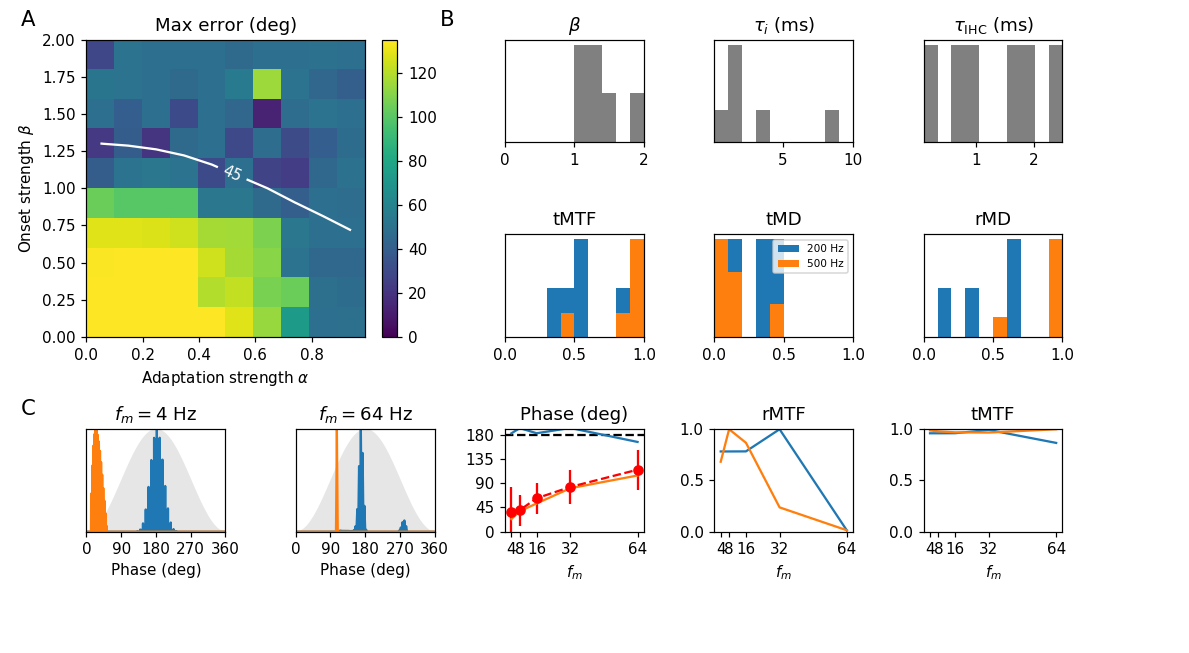

Best params [13.536] {'taui_ms': 8.598140934853731, 'level': 24.07812114121355, 'taua_ms': 0.10059889414031392, 'tauihc_ms': 0.9410288919567948, 'beta': 1.5555555555555554, 'taue_ms': 0.10228558046016918, 'alpha': 0.66, 'fc_Hz': 200, 'gamma': 0.6947503543998015}
Best params [13.528] {'taui_ms': 8.598140934853731, 'level': 24.07812114121355, 'taua_ms': 0.10059889414031392, 'tauihc_ms': 0.9410288919567948, 'beta': 1.5555555555555554, 'taue_ms': 0.10228558046016918, 'alpha': 0.66, 'fc_Hz': 500, 'gamma': 0.6947503543998015}


In [8]:
def plot_carrier_frequency(M, num_params, params,
                           weighted, error_func_name,
                           max_error=30, discount_200=3.):
    # always use the same random seed for cacheing
    seed(34032483)    
    # Set up ranges of variables, and generate arguments to pass to model function
    vx, vy = selected_axes = ('alpha', 'beta')
    error_func = error_functions[error_func_name]
    axis_ranges = dict((k, linspace(*(v+(M,)))) for k, v in params.items() if k in selected_axes)
    axis_ranges['temp'] = zeros(num_params)
    array_kwds = meshed_arguments(selected_axes+('temp',), params, axis_ranges)
    del array_kwds['temp']
    # run the model at 500 Hz
    array_kwds['fc_Hz'] = 500
    seed(342309432)
    res500 = simple_model(M*M*num_params, array_kwds, update_progress='text', use_standalone_openmp=True)
    res500 = simple_model_results(M*M*num_params, res500, error_func, weighted=weighted,
                                  interpolate_bmf=True, shape=(M, M, num_params))
    # run the model at 200 Hz
    array_kwds['fc_Hz'] = 200
    seed(342309432)
    res200 = simple_model(M*M*num_params, array_kwds, update_progress='text', use_standalone_openmp=True)
    res200 = simple_model_results(M*M*num_params, res200, error_func, weighted=weighted,
                                  target_phase=ones(5)*pi,
                                  interpolate_bmf=True, shape=(M, M, num_params))
    # analyse
    res = res200
    mse = maximum(res500.mse, res200.mse/discount_200)
    mse = mse*180/pi
    mse_summary = amin(mse, axis=2)
    cell_properties = dict([
        ('tMTF', (mean(res200.raw_measures['vs'], axis=3), mean(res500.raw_measures['vs'], axis=3), 0, 1)),
        ('tMD', (res200.moddepth['vs'], res500.moddepth['vs'], 0, 1)),
        ('rMD', (res200.moddepth['mean'], res500.moddepth['mean'], 0, 1)),
        ])
    
    # Plot the data
    fig = figure(figsize=(10, 5.5))
    gs = GridSpec(3, 5)
    
    # Error map
    extent = (params[vx]+params[vy])
    subplot(gs[0:2, 0:2]) # error
    #mse_summary = median_filter(mse_summary, mode='nearest', size=5)
    mse_summary_med = median_filter(mse_summary, mode='nearest', size=5)
    mse_summary_min = minimum_filter(mse_summary, mode='nearest', size=3)
    mse_summary_blur = gaussian_filter(mse_summary_min, 3, mode='nearest')    
    imshow(mse_summary, origin='lower left', aspect='auto',
           interpolation='nearest', extent=extent, vmin=0, vmax=135)
    colorbar()
    cs = contour(mse_summary_blur, origin='lower',
                 levels=[15, 30, 45], colors='w',
                 extent=extent)
    clabel(cs, colors='w', inline=True, fmt='%d')
    title('Max error (deg)')
    xlabel(r'Adaptation strength $\alpha$')
    ylabel(r'Onset strength $\beta$')

    # Region examples
    ax_lf = subplot(gs[2, 0])
    ax_hf = subplot(gs[2, 1])
    ax_phase = subplot(gs[2, 2])
    ax_rmtf = subplot(gs[2, 3])
    ax_tmtf = subplot(gs[2, 4])
    ax_lf.set_title(r'$f_m=4$ Hz')
    ax_hf.set_title(r'$f_m=64$ Hz')
    ax_rmtf.set_title('rMTF')
    ax_tmtf.set_title('tMTF')
    phase = linspace(0, 2*pi, 100)
    env = 0.5*(1-cos(phase))
    for ax in [ax_lf, ax_hf]:
        ax.fill_between(phase*180/pi, 0, env, color=(0.9,) * 3, zorder=-2)
        ax.set_xlabel('Phase (deg)')
        ax.set_xticks([0, 90, 180, 270, 360])
        ax.set_xlim(0, 360)
        ax.set_yticks([])
        ax.set_ylim(0, 1)
    for ax in [ax_rmtf, ax_tmtf, ax_phase]:
        ax.set_xlabel(r'$f_m$')
        ax.set_xticks([4, 8, 16, 32, 64])
        ax.set_ylim(0, 1)
    ax_phase.errorbar(dietz_fm/Hz, dietz_phase*180/pi, yerr=dietz_phase_std*180/pi, fmt='--or', label='Data')
    ax_phase.set_ylim(0, 190)
    ax_phase.set_yticks([0, 45, 90, 135, 180])
    ax_phase.axhline(180, ls='--', c='k')
    ax_phase.set_title('Phase (deg)')
    # Construct best parameter values
    best_params = {}
    idx_best = unravel_index(argmin(mse), mse.shape) # a triple
    for paramname in params.keys():
        best_params[paramname] = reshape(res.raw.params[paramname], (M, M, num_params))[idx_best]
    for fc_Hz, c, target_phase in [(200, 'C0', ones(5)*pi),
                                   (500, 'C1', None)]:
        best_params['fc_Hz'] = fc_Hz
        cur_res = simple_model(1, best_params, record=['out'])
        cur_res = simple_model_results(1, cur_res, error_func, weighted, interpolate_bmf=True,
                                       target_phase=target_phase)
        print 'Best params', cur_res.mse*180/pi, best_params
        out = cur_res.raw.out
        t = cur_res.raw.t
        for j, ax in [(0, ax_lf), (-1, ax_hf)]:
            I = logical_and(t>=cur_res.raw.start_time[j], t<cur_res.raw.end_time[j])
            phase = ((2*pi*dietz_fm[j]*t[I])%(2*pi))*180/pi
            ax.plot(phase, normed(out[0, j, I]), c=c)
        ax_phase.plot(dietz_fm, cur_res.peak_phase[0]*180/pi, c=c)
        ax_rmtf.plot(dietz_fm, cur_res.norm_measures['mean'].T, c=c)
        ax_tmtf.plot(dietz_fm, cur_res.raw_measures['vs'].T, c=c)

    # Parameter histograms
    for i, paramname in enumerate(['beta', 'taui_ms', 'tauihc_ms',
                                   'tMTF', 'tMD', 'rMD']):
        subplot(gs[i//3, 2+i%3])
        if paramname in res.raw.params:
            values = reshape(res.raw.params[paramname], (M, M, num_params))
            low, high = params[paramname]
            v = values[mse<max_error]
            hist(v, bins=M, range=(low, high), histtype='stepfilled', fc='gray')
        else:
            values200, values500, low, high = cell_properties[paramname]
            for values, c, lab in [(values200, 'C0', '200 Hz'), (values500, 'C1', '500 Hz')]:
                v = values[mse<max_error]
                hy, hx = histogram(v, bins=M, range=(low, high))
                bar(hx[:-1], 1.0*hy/amax(hy), diff(hx), align='edge', color=c, edgecolor='none', label=lab)
                #hist(v, bins=M, range=(low, high), histtype='stepfilled', fc=c, label=lab)
            if paramname=='tMD':
                legend(loc='upper right', fontsize='x-small')
        xlim(low, high)
        yticks([])
        title(latex_parameter_names.get(paramname, paramname))

    # Tight layout
    tight_layout()
    # annotate
    for c, loc in zip('ABC', [(0, 0), (0, 2), (2, 0)]):
        bbox = gs[loc].get_position(fig)
        text(bbox.x0-0.06, bbox.y1+0.05, c, fontsize=14, transform=fig.transFigure,
             horizontalalignment='left', verticalalignment='top')

plot_carrier_frequency(
    #M=10, num_params=20,
    #M=20, num_params=100,
    #M=40, num_params=200,
    #M=80, num_params=500, # 3.2M param sets, several hours
    #M=40, num_params=2000, # 3.2M param sets, several hours
    M=10, num_params=20,
    weighted=False, error_func_name='Max error',
    max_error=30,
    params=dict(
        taui_ms=(0.1, 10), taue_ms=(0.1, 2.5), taua_ms=(0.1, 10),
        level=(-25, 25), alpha=(0, 0.99), beta=(0, 2),
        gamma=(0.1, 1),
        tauihc_ms=(0.1, 2.5),
        ),
    )
savefig('figure_carrier_frequency.pdf')

show()